#**Data Retreival**

Research data is retreived programmatically from Kaggle through the Kaggle API using the python-kaggle library. The required data is sourced using the Kaggle querying functionality to find data from the appropirate source and of the appropriate size and file formatting.

We get a few different types of data from Kaggle mainly; medical research data, social sciene research data / surverys and geographical and economic stats as these are soruced from individual for whom this tool is most relevent too

We require to have equal data of each missingness mechanism to train both of the machine learning models (missing mechanism multiclassification model and imputation algorithm recommendation multiclassification model) that are going to be present inside of the pipeline. Data of these specific mechansims is hard to find (at least data the comes with comformation of it's missingness mechanism) so we use algorithms to transform a dataset retrieved from Kaggle to have missing data of each mechansim which we store along with the original. We do this so we have the definitive missingness mechansim for each dataset along with the original data which will help us evaulate the imputation methods on each dataset and for each type of mechansim

#Mounting the Google drive

This allows us to access all the data we store in this project as well at the file system

In [ ]:
# Need to mount drive to access and save files that store model stats, figures, etc
from google.colab import drive
import os


# Mount the drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Final_year_project") # Path of reference for imports
folder = os.path.join("/content/drive/MyDrive/Final_year_project") # Reference for future use when importing / exporting files

# View files in the current working directory
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data
datasets
getImputationModelsStats.ipynb
getMissingData.ipynb
imputationRecommendationModel.ipynb
imputationRecommendationModelRandomForest.ipynb
machine_learning_model
pipeline.ipynb
random_forest_machine_learning_model
root


# Imports and installs

This section import and/or installs all neccessary python libraries

In [ ]:
# Pip installs / commmands for setup
!pip install kaggle
!sudo apt install pipx
!pipx install hatch
!hatch run install-deps
!hatch run compile


# Set up config for Kaggle
!chmod 600 ./root/.kaggle/kaggle.json  # Secure the file


# Export environment variables incase the json file doesn't work
os.environ["KAGGLE_USERNAME"] = "joshuamorgan099999"
os.environ["KAGGLE_KEY"] = "4eb83d4678fd604d6b6ef391df3b337b"
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"  # Replace with actual path if needed


# Imports
from kaggle.api.kaggle_api_extended import KaggleApi
from sklearn.preprocessing import LabelEncoder
import kaggle
import os
import gc
import zipfile
import pandas as pd
import shutil
import random
import numpy as np
import time


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-font-awesome fonts-lato javascript-common libjs-bootstrap4
  libjs-highlight.js libjs-lunr libjs-modernizr libjs-popper.js libjs-sizzle
  mkdocs node-jquery python-babel-localedata python3-argcomplete python3-babel
  python3-click python3-colorama python3-jinja2 python3-livereload
  python3-packaging python3-pip-whl python3-psutil python3-pyinotify
  python3-setuptools-whl python3-tornado python3-tz python3-userpath
  python3-venv python3-yaml python3.10-venv sphinx-rtd-theme-common
Suggested packages:
  apache2 | lighttpd | httpd libjs-es5-shim ghp-import mkdocs-doc nodejs
  python-jinja2-doc coffeescript node-less node-uglify python-livereload-doc
  python3-django python3-flask python3-slimmer python-psutil-doc
  python-pyinotify-doc python3-pycurl python-tornado-doc python3-twisted
The following NEW packages will be installed:


# Getting the data from Kaggle

In this section we query the kaggle API to retreive the data that we will go on to augment, first saving the original copy for later comparisons (evaluation of imputation algorithms)


In [ ]:
def query_kaggle_datasets(queries: list, tempStore_path: str, download_path: str, pages: int, augment: bool, augment_prob: float) -> bool:

  # Initialize Kaggle API
  api = KaggleApi()
  api.authenticate()

  # initailise datasets (to be added to)
  datasets = []

  # Divide number of pages into sets of 20
  chunks_20 = [min(20, pages - i) for i in range(0, pages, 20)]


  # Fetch datasets from Kaggle matching the queries
  for query in queries:
    print(f"\n\nQuerying for {query}", "-----------------------------------------------------------------------------\n")


    for index in range(0, len(chunks_20)):
      pages_lower_bound = sum(chunks_20[:index]) + 1 if index > 0 else 1
      pages_upper_bound = sum(chunks_20[:index + 1])


      # try:

      # Make the program sleep for 5 seconds to avoid multiple call missues with Kaggle API
      time.sleep(5)


      # Run multiple for loops separetly to avoid multiple call missues with Kaggle API
      for page_index in range(pages_lower_bound, pages_upper_bound + 1):
        datasets = datasets + api.dataset_list(
          search=query,
          page=page_index,
          max_size=5000
        )

      # except Exception as e:

      #   # Nothing needs to happen here we just need to catch the error
      #   _ = 1


    # Make the program sleep for 15 seconds each query to avoid multiple call missues with Kaggle API
    time.sleep(15)


  # If there are no datasets the function has failed
  if len(datasets) == 0:


    print(datasets)
    print("NO DATA")
    return False


  # Make sure the download directorys exists
  if not os.path.exists(tempStore_path):
    os.makedirs(tempStore_path)


  if not os.path.exists(download_path):
    os.makedirs(download_path)


  # Go through each dataset, download, clean and save
  for dataset in datasets:
    time.sleep(2)


    # Via testing it was found to be possible to get a URL (reference) that is no long available at least for public use
    try:

      # Download the dataset (this will download the dataset as a zip file)
      downloaded_dataset = api.dataset_download_files(dataset.ref, path=tempStore_path)

      print(f"Dataset name: {dataset.ref}")

      # Get the zip files in the dataset temporary folder (there should be only 1)
      zip_file = [file for file in os.listdir(tempStore_path) if file.endswith('.zip')][0]

      # Specify the zip file path
      zip_file_path = os.path.join(tempStore_path, zip_file)


      # Unzip the file
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(tempStore_path)


      # pandas will read all json or csv files - tempStore_path
      csv_files = [file for file in os.listdir(tempStore_path) if file.endswith('.csv')]
      json_files = [file for file in os.listdir(tempStore_path) if file.endswith('.json')]


      # Turn all csv files to json and save them in the new folder
      for file in csv_files:


        # Via testing it was found reading these files sometimes causes issues
        try:
          df = pd.read_csv(os.path.join(tempStore_path, file), nrows=1000)

          # Remove any column with missing data
          df_cleaned = df.dropna()

          # Save the csv file to the original data file as json
          file = file.replace(".csv", ".json")


          # Randomly augment dataframe
          if augment and random.uniform(0, 1) < augment_prob:
            df_cleaned = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)


            if random.uniform(0, 1) < 0.2:
              df_cleaned = df_cleaned.sample(frac=1.5, replace=True, random_state=42)

            elif random.uniform(0, 1) < 0.3:
              df_cleaned = df_cleaned.sample(frac=0.5, replace=True, random_state=42)


          df_cleaned.to_json(os.path.join(download_path, file), orient='records', lines=True)

        except:
          _ = -1


      # Sanatise all json files and save them in the new folder
      for file in json_files:


        # Via testing it was found reading these files sometimes causes issues
        try:
          df = pd.read_json(os.path.join(tempStore_path, file), nrows=1000)

          # Remove any column with missing data
          df_cleaned = df.dropna()


          # Randomly augment dataframe
          if augment and random.uniform(0, 1) < augment_prob:
            df_cleaned = df_cleaned.sample(frac=1, random_state=42).reset_index(drop=True)


            if random.uniform(0, 1) < 0.2:
              df_cleaned = df_cleaned.sample(frac=1.5, replace=True, random_state=42)

            elif random.uniform(0, 1) < 0.3:
              df_cleaned = df_cleaned.sample(frac=0.5, replace=True, random_state=42)


          df_cleaned.to_json(os.path.join(download_path, file), orient='records', lines=True)


          # Save the csv file to the original data file
          df_cleaned.to_json(os.path.join(download_path, file), orient='records', lines=True)

        except:
          _ = -1


      # Clean out the entire dataset folder that temporarily stores the results of Kaggle downloads
      if os.path.exists(tempStore_path):

          # Delete folder and everything in it
          shutil.rmtree(tempStore_path)

          # Re-make directory
          os.makedirs(tempStore_path)

    except Exception as e:
      print("\n", f"Dataset couldn't be downloaded: {dataset.ref}", f"Dataset caused exception: {e}", "\n")


  return True

# Augmentation functions

In this section of the notebook we create the functions needed to augment each of the saved datasets retreived from the Kaggle API with each missingness mechanism; MCAR, MAR, MNAR

#### MCAR Augmentation function

To generate MCAR data from an already complete dataset we implement the Drawing from a random distribution algorithm; For each feature in the dataset we generate an array of length n where each variable is randomised between 1 and 0 (missingness pattern). For each ith subject in the array we generate a float, if this float is less than the probability then the ith subject in the datasets feature will go missing.





In [ ]:
def augment_MCAR(df: pd.DataFrame, prob: float) -> list[pd.DataFrame, str]:

  # Randomly select a feature for MCAR augmentation
  features = list(df.columns)
  missingness_column = features[random.randint(0, len(features)-1)]

  # Generate binary missingness pattern - 0 is missing, 1 is not missing
  missingness_pattern = np.random.choice([0, 1], size=len(df), p=[prob, 1-prob])

  # Apply missingness patten to the dataframe
  df[missingness_column] = df[missingness_column].mask(missingness_pattern == 0)


  return df, missingness_column

#### MAR Augmentation function

To generate MAR data from an already complete dataset we implement the single cutoff method; A variable Y is dependent on X which has a cutoff point a, the missing data rule is then if X >= a then the chance of Y going missing is b, else if X < a then the chance of Y going missing is c. Therefore to apply this mechanism we create a missing data rule (predictor) with the parameters set so that the expected percentage of missingness is equivalent to the desired percentage of missingness.

In [ ]:
def augment_MAR(df: pd.DataFrame, b_prob: float, c_prob: float) -> list[pd.DataFrame, str]:

  # Randomly select a feature for MAR augmentation
  features = list(df.columns)
  missingness_column = features[random.randint(0, len(features)-1)]

  # Randomly select dependent column
  features.remove(missingness_column)
  dependent_column = features[random.randint(0, len(features)-1)]

  # Initialize LabelEncoder
  encoder = LabelEncoder()
  df_original = df.copy()


  # Handle the independent column not being numeric
  if not pd.api.types.is_numeric_dtype(df[missingness_column]):
      df[missingness_column] = df[missingness_column].astype(str)
      df[missingness_column] = encoder.fit_transform(df[missingness_column])


  # Handle the dependent column not being numeric
  if not pd.api.types.is_numeric_dtype(df[dependent_column]):
      df[dependent_column] = df[dependent_column].astype(str)
      df[dependent_column] = encoder.fit_transform(df[dependent_column])


  # Randomly select value from depedent columns distribution to be the cutoff point
  cutoff = random.randint(min(df[dependent_column]), max(df[dependent_column])) if pd.api.types.is_numeric_dtype(df[dependent_column]) else list(df[dependent_column])[random.randint(0, df.shape[0]-1)]

  # Generate binary missingness pattern - 0 is missing, 1 is not missing
  missingness_pattern = np.array([np.random.binomial(1, 1-b_prob) if value >= cutoff else np.random.binomial(1, 1-c_prob) for value in df[dependent_column]])

  # Apply missingness patten to the dataframe
  df_original[missingness_column] = df_original[missingness_column].mask(missingness_pattern == 0)


  return df_original, missingness_column

#### MNAR Augmentation function

To generate MNAR data from an already complete dataset we implement the single cutoff method replacing the X variable (predictor feature) with the Y variable (missingness / indicator feature); A variable Y has a cutoff point a, the missing data rule is then if Y >= a then the chance of Y going missing is b, else if Y < a then the chance of Y going missing is c. Therefore to apply this mechanism we create the same missing data rule (predictor as in the single cutoff method for MAR but set the predictor and the indicator to the same variable.

In [ ]:
def augment_MNAR(df: pd.DataFrame, b_prob: float, c_prob: float) -> list[pd.DataFrame, str]:

  # Randomly select a feature for MAR augmentation
  features = df.columns
  missingness_column = features[random.randint(0, len(features)-1)]

  # Dependant column is the same as the missingness column
  dependent_column = missingness_column

  # Initialize LabelEncoder
  encoder = LabelEncoder()
  df_original = df.copy()


  # Handle the missingness column not being numeric
  if not pd.api.types.is_numeric_dtype(df[dependent_column]):
    df[dependent_column] = df[dependent_column].astype(str)
    df[dependent_column] = encoder.fit_transform(df[dependent_column])


  # Randomly select value from depedent columns distribution to be the cutoff point
  cutoff = random.randint(min(df[dependent_column]), max(df[dependent_column])) if pd.api.types.is_numeric_dtype(df[dependent_column]) else list(df[dependent_column])[random.randint(0, df.shape[0]-1)]

  # Generate binary missingness pattern - 0 is missing, 1 is not missing
  missingness_pattern = np.array([np.random.binomial(1, 1-b_prob) if value >= cutoff else np.random.binomial(1, 1-c_prob) for value in df[dependent_column]])

  # Apply missingness patten to the dataframe
  df_original[dependent_column] = df_original[dependent_column].mask(missingness_pattern == 0)


  return df_original, dependent_column

# Augmentation execution

In this section we execute each of the previously defined augmentation functions for each missingness mechansim, once the data has been augmented we save the files for later use


We retreive 60 pages each with 20 datasets meaning we should have (60 * 20) 1200 datasets. Then since datasets are repeated for each missingness mechansim we should have (3 * 1200) 3600 datasets for our machine learning models to train on

In [ ]:
def generate_missing_mechansim_datasets(download_path: str, mcar_path: str, mar_path: str, mnar_path: str):

    # They should only be json files
    json_files = [file for file in os.listdir(download_path) if file.endswith('.json')]


    # Augment with each missingess mechansim and save
    for file in json_files:
      print(f"\n\nAugmenting {file}")

      # Get the datasets for each mechansim
      df_mcar = pd.read_json(os.path.join(download_path, file), lines=True)
      df_mar = df_mcar.copy()
      df_mnar = df_mcar.copy()




      """Augment with MCAR"""
      # In the event there is an error (unlikely as this function is reasonably robust) we don't want to stop execution
      try:
        # ----------------------------------------------------------------------------

        # Generate random probability to apply
        prob = random.uniform(0.0, 1.0)
        df_mcar, _ = augment_MCAR(df_mcar , prob)

        # Save the MCAR augmented data
        df_mcar.to_json(os.path.join(mcar_path, file), orient='records', lines=True)


        del df_mcar
        # ----------------------------------------------------------------------------
      except:
        print(f"Failed when augmenting {file} for MCAR")




      """Augment with MAR"""
      # In the event there is an error (unlikely as this function is reasonably robust) we don't want to stop execution
      try:
        # ----------------------------------------------------------------------------

        # Generate random probabilities to apply
        b_prob = random.uniform(0.0, 1.0)
        c_prob = random.uniform(0.0, 1.0)
        df_mar, _ = augment_MAR(df_mar , b_prob, c_prob)

        # Save the MCAR augmented data
        df_mar.to_json(os.path.join(mar_path, file), orient='records', lines=True)


        del df_mar
        # ----------------------------------------------------------------------------
      except:
        print(f"Failed when augmenting {file} for MAR")




      """Augment with MNAR"""
      # In the event there is an error (unlikely as this function is reasonably robust) we don't want to stop execution
      try:
        # ----------------------------------------------------------------------------

        # Generate random probabilities to apply
        b_prob = random.uniform(0.0, 1.0)
        c_prob = random.uniform(0.0, 1.0)
        df_mnar, _ = augment_MNAR(df_mnar , b_prob, c_prob)

        # Save the MCAR augmented data
        df_mnar.to_json(os.path.join(mnar_path, file), orient='records', lines=True)


        del df_mnar
        # ----------------------------------------------------------------------------
      except:
        print(f"Failed when augmenting {file} for MNAR")




"""Execute all the functionality"""

# # Specify the paths
# download_path = './datasets'
# original_path = "./data/Original"
# mcar_path = "./data/MCAR"
# mar_path = "./data/MAR"
# mnar_path = "./data/MNAR"
# imputation_stats_folder = "imputation_stats"
# imputation_stats_file = "imputation_stats.json"

# queries = ["medical research", "geography", "social research", "population stats"]


# # Query the Kaggle API
# is_downloaded = query_kaggle_datasets(queries, download_path, original_path, 120, True, 0.1)
# print("-----------------------------------------------------------------------------",
#       "Query Failed" if not is_downloaded else "Query succeded",
#       "-----------------------------------------------------------------------------\n\n\n")


# # Augment the Kaggle datasets for each missingness mechansim
# is_augmented = generate_missing_mechansim_datasets(original_path, mcar_path, mar_path, mnar_path)
# print("-----------------------------------------------------------------------------",
#       "Augmentation Failed" if not is_augmented else "Augmentation succeded",
#       "-----------------------------------------------------------------------------\n\n\n")

'Execute all the functionality'

# **Testing**

In this section we go through and test the code to validate the logic of the functionality and verify that it does exactly what we expect / want it to do. In the following sections we run the following types of tests on the code base:

1.   Manual functional testing



### Manual Functional Testing

Manual testing is executed to a specification (test case specification) which requires human intervention (manual execution by testers) without the use of any automation tools

<br>

### Test case specification:
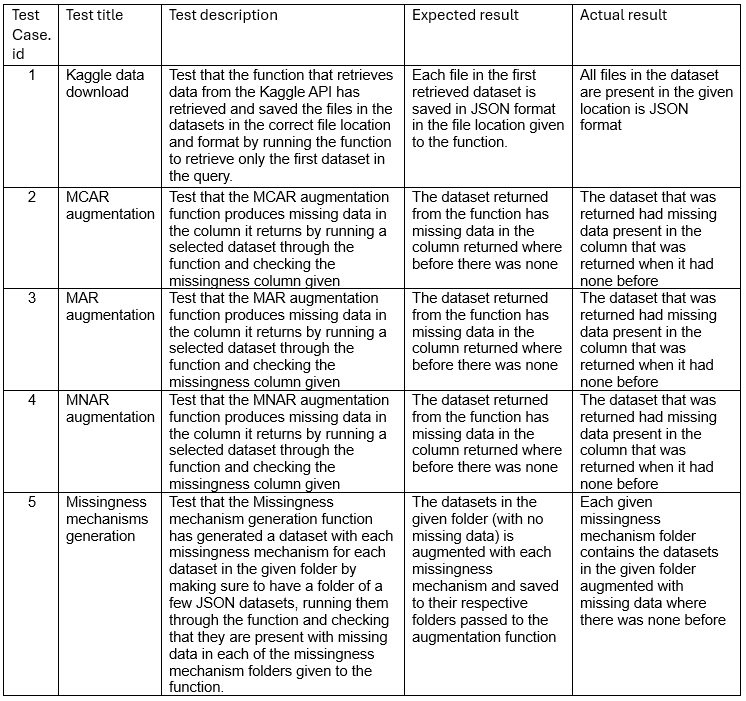

#### Test 1 - Kaggle data download
Test that the function that retrieves data from the Kaggle API has retrieved and saved the files in the datasets in the correct file location and format by running the function to retrieve only the first dataset in the query.

In [ ]:
"""Initialise variables to run the test"""

# Define the query
queries = ["medical research"]

# Specify the paths to download the datasets
download_path = './datasets'
original_path = "./data/Original"




"""Run the test"""
is_downloaded = query_kaggle_datasets(queries, download_path, original_path, 2, True, 0.1)

is_downloaded_message = "Test passed: Datasets downloaded" if is_downloaded else "Test failed: Datasets not downloaded"

print(is_downloaded_message)



Querying for medical research -----------------------------------------------------------------------------

Dataset URL: https://www.kaggle.com/datasets/uom190346a/disease-symptoms-and-patient-profile-dataset
Dataset name: uom190346a/disease-symptoms-and-patient-profile-dataset
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/heart-failure-clinical-data
Dataset name: andrewmvd/heart-failure-clinical-data
Dataset URL: https://www.kaggle.com/datasets/utkarshxy/kidney-stone-data
Dataset name: utkarshxy/kidney-stone-data
Dataset URL: https://www.kaggle.com/datasets/zsinghrahulk/liver-disorders
Dataset name: zsinghrahulk/liver-disorders
Dataset URL: https://www.kaggle.com/datasets/vaibhavsuman/heart-failure-dataset
Dataset name: vaibhavsuman/heart-failure-dataset
Dataset URL: https://www.kaggle.com/datasets/thedevastator/predicting-heart-disease-risk-using-clinical-var
Dataset name: thedevastator/predicting-heart-disease-risk-using-clinical-var
Dataset URL: https://www.kaggle.com/d

#### Test 2 - MCAR augmentation

Test that the MCAR augmentation function produces missing data in the column it returns by running a selected dataset through the function and checking the missingness column given

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
original_path = "./data/Original"

# Get a dataset to test the augmentation function
df = pd.read_json(os.path.join(original_path, "diagnosis.json"), lines=True, nrows=10)
prob = 0.5




"""Run the test"""

# Run the augmentation function
print(f"Before dataframe: \n {df} \n\n")
df, missingness_column = augment_MCAR(df, prob)
print(f"After dataframe: \n {df} \n\n")

# Check there is missing data in the missingness column
is_missing = df[missingness_column].isna().any()

is_missing_message = "Test passed: Missing data present" if is_missing else "Test failed: Missing data not present"

print(is_missing_message)

Before dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5      no     yes      no      no      no      no      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no     yes      no      no      no      no      no
3     36.0      no      no     yes     yes     yes     yes      no
4     36.0      no     yes      no      no      no      no      no
5     36.0      no     yes      no      no      no      no      no
6     36.2      no      no     yes     yes     yes     yes      no
7     36.2      no     yes      no      no      no      no      no
8     36.3      no      no     yes     yes     yes     yes      no
9     36.6      no      no     yes     yes     yes     yes      no 


After dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5      no     yes      no      no      no     NaN      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no  

#### Test 3 - MAR augmentation

Test that the MAR augmentation function produces missing data in the column it returns by running a selected dataset through the function and checking the missingness column given

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
original_path = "./data/Original"

# Get a dataset to test the augmentation function
df = pd.read_json(os.path.join(original_path, "diagnosis.json"), lines=True, nrows=10)
b_prob = 0.1
c_prob = 0.5




"""Run the test"""

# Run the augmentation function
print(f"Before dataframe: \n {df} \n\n")
df, missingness_column = augment_MAR(df, b_prob, c_prob)
print(f"After dataframe: \n {df} \n\n")

# Check there is missing data in the missingness column
is_missing = df[missingness_column].isna().any()

is_missing_message = "Test passed: Missing data present" if is_missing else "Test failed: Missing data not present"

print(is_missing_message)

Before dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5      no     yes      no      no      no      no      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no     yes      no      no      no      no      no
3     36.0      no      no     yes     yes     yes     yes      no
4     36.0      no     yes      no      no      no      no      no
5     36.0      no     yes      no      no      no      no      no
6     36.2      no      no     yes     yes     yes     yes      no
7     36.2      no     yes      no      no      no      no      no
8     36.3      no      no     yes     yes     yes     yes      no
9     36.6      no      no     yes     yes     yes     yes      no 


After dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5     NaN     yes      no      no      no      no      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no  

#### Test 4 - MNAR augmentation

Test that the MNAR augmentation function produces missing data in the column it returns by running a selected dataset through the function and checking the missingness column given

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
original_path = "./data/Original"

# Get a dataset to test the augmentation function
df = pd.read_json(os.path.join(original_path, "diagnosis.json"), lines=True, nrows=10)
b_prob = 0.1
c_prob = 0.5




"""Run the test"""

# Run the augmentation function
print(f"Before dataframe: \n {df} \n\n")
df, missingness_column = augment_MNAR(df, b_prob, c_prob)
print(f"After dataframe: \n {df} \n\n")

# Check there is missing data in the missingness column
is_missing = df[missingness_column].isna().any()

is_missing_message = "Test passed: Missing data present" if is_missing else "Test failed: Missing data not present"

print(is_missing_message)

Before dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5      no     yes      no      no      no      no      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no     yes      no      no      no      no      no
3     36.0      no      no     yes     yes     yes     yes      no
4     36.0      no     yes      no      no      no      no      no
5     36.0      no     yes      no      no      no      no      no
6     36.2      no      no     yes     yes     yes     yes      no
7     36.2      no     yes      no      no      no      no      no
8     36.3      no      no     yes     yes     yes     yes      no
9     36.6      no      no     yes     yes     yes     yes      no 


After dataframe: 
    Column1 Column2 Column3 Column4 Column5 Column6 Column7 Column8
0     35.5      no     NaN      no      no      no      no      no
1     35.9      no      no     yes     yes     yes     yes      no
2     35.9      no  

#### Test 5 - Missingness mechanisms generation

Test that the Missingness mechanism generation function has generated a dataset with each missingness mechanism for each dataset in the given folder by making sure to have a folder of a few JSON datasets, running them through the function and checking that they are present with missing data in each of the missingness mechanism folders given to the function.

In [ ]:
"""Initialise variables to run the test"""

# Get all the original data

# Specify the paths to download the datasets
original_path = "./data/Original"
mcar_path = "./data/MCAR"
mar_path = "./data/MAR"
mnar_path = "./data/MNAR"




"""Run the test"""
is_generated = generate_missing_mechansim_datasets(original_path, mcar_path, mar_path, mnar_path)

is_generated_message = "Test passed: Missingness mechansim datasets generated" if is_generated else "Test failed: Missingness mechansim datasets not generated"

print(is_generated_message)



Augmenting Disease_symptom_and_patient_profile_dataset.json


Augmenting heart_failure_clinical_records_dataset.json


Augmenting kidney_stone_data.json


Augmenting liver.json


Augmenting liver_details.json
Failed when augmenting liver_details.json for MCAR
Failed when augmenting liver_details.json for MAR
Failed when augmenting liver_details.json for MNAR


Augmenting Heart_Failure_Details.json
Failed when augmenting Heart_Failure_Details.json for MNAR


Augmenting Heart_Disease_Prediction.json


Augmenting diabetes_data.json
Failed when augmenting diabetes_data.json for MAR


Augmenting bloodtypes.json
Failed when augmenting bloodtypes.json for MAR
Failed when augmenting bloodtypes.json for MNAR


Augmenting filtered_thyroid_data.json


Augmenting SNOMED_mappings_scored.json
Failed when augmenting SNOMED_mappings_scored.json for MAR


Augmenting SNOMED_mappings_unscored.json
Failed when augmenting SNOMED_mappings_unscored.json for MAR


Augmenting blood.json


Augmenting daily_an